***
In this notebook, we will show how to create pcraster maps to represent soil and land hydrologic properties for a SPHY model input.
***

# 00. Load Packages

In [39]:
import os, shutil
import pcraster as pcr
import pcr_tool

import numpy as np
import cartopy

# 01. Basic Setup for a Bhutan watershed (Punatsangchhu, Wangchhu, Amochhu, and Jaldakah)

In [40]:
epsg_model = 5266 # Bhutan National Grid: a transverse Mercator projection
epsg_lonlat = 4326 # the common lat-lon coordinate reference system

path_data = os.path.join('..', 'data')
path_output = os.path.join('..', 'input') # the "input" folder will be directly used as an input path for the SPHY model run
os.makedirs(path_output, exist_ok = True)

# plotting options
flag_plot_aguila = True
flag_plot_cartopy = True

# Bhutan Administrative Boundaries (Level 1) to be added in a plot
path_shape = os.path.join(path_data, 'SHAPE', 'btn_admbnda_adm1_bnlc_20201026.shp')
shape_geometry = cartopy.io.shapereader.Reader(path_shape).geometries()
shape_feature = cartopy.feature.ShapelyFeature(shape_geometry, crs = cartopy.crs.PlateCarree(), facecolor = 'none', linewidth = 0.25)

# 02. Load Clonemap and DEM

First, we need to declare the class that we will be using throughout this notebook, with an EPSG to define a clonemap.

In [41]:
print(f'- Input EPSG:\n{epsg_model}')
map_clone = pcr_tool.clonemap(epsg = epsg_model)

- Input EPSG:
5266


Let's load the clonemap and DEM that we generated in the previous notebook.

In [42]:
# load clonemap
path_clonemap = os.path.join(path_output, 'clone.map')
print(f'- Input PCRaster Path for Clonemap:\n{path_clonemap}')
map_clone.load_clonemap(path = path_clonemap)

# load DEM
path_dem = os.path.join(path_output, 'dem.map')
print(f'- Input PCRaster Path for DEM:\n{path_dem}')
map_dem = map_clone.read_pcraster(path = path_dem)
map_clone.set_dem(map_dem)

print('- Outputs:')
print(map_dem)

# plots
if flag_plot_aguila:
    pcr.aguila(map_clone.clonemap)
    pcr.aguila(map_dem)

- Input PCRaster Path for Clonemap:
../input/clone.map
- Input PCRaster Path for DEM:
../input/dem.map
- Outputs:


# 03. Set Soil-Related Hydrologic Properties

First, we need to define the depths for the rootzone and subsoil layers. Let's assume the uniform depths for both layers.

- Outputs:
write_pcraster: written to ../input/root_depth.map.
write_pcraster: written to ../input/sub_depth.map.


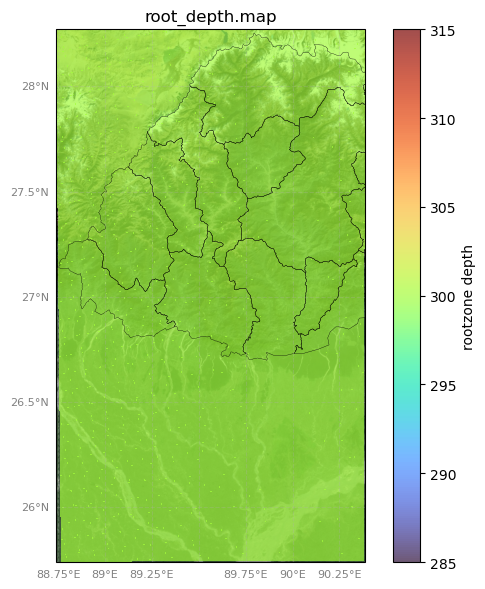

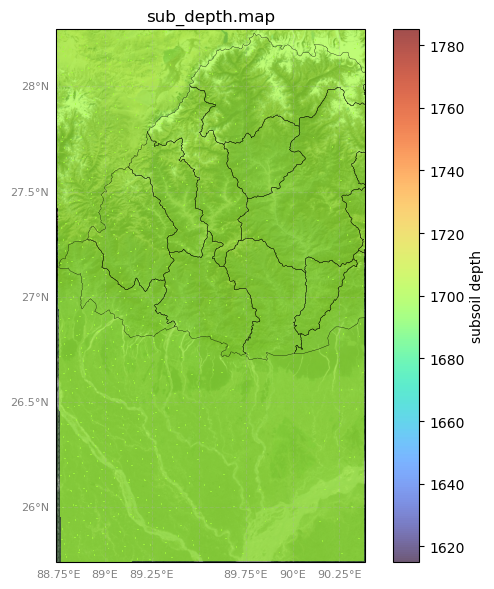

In [43]:
rootdepth = 300 # rootzone depth (mm)
subdepth = 1700 # subsoil depth (mm)

array_rootdepth = rootdepth * np.ones([map_clone.nrow, map_clone.ncol]) # create numpy.ndarray with the same numbers of clonemap rows and columns
array_subdepth = subdepth * np.ones([map_clone.nrow, map_clone.ncol]) # create numpy.ndarray with the same numbers of clonemap rows and columns
# conversion from numpy.ndarray to pcraster.Field
map_rootdepth = map_clone.from_numpy(
    array = array_rootdepth, # numpy.ndarray to convert into pcraster.Field
    datatype = pcr.Scalar, # pcraster data type
    missing_value = 0, # missing value to assign
    ) # for rootzone layer
map_subdepth = map_clone.from_numpy(
    array = array_subdepth, # numpy.ndarray to convert into pcraster.Field
    datatype = pcr.Scalar, # pcraster data type
    missing_value = 0, # missing value to assign
    ) # for subsoil layer

print('- Outputs:')
print(map_rootdepth)
print(map_subdepth)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_depth.map'), # path to write in the pcraster format
    field = map_rootdepth, # pcraster.Field to write
    )
map_clone.write_pcraster(
    path = os.path.join(path_output, 'sub_depth.map'), # path to write in the pcraster format
    field = map_subdepth, # pcraster.Field to write
    )

# plots
if flag_plot_aguila:
    pcr.aguila(map_rootdepth)
    pcr.aguila(map_subdepth)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rootdepth, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_depth.map', # matplotlib figure title
        clabel = 'rootzone depth', # matplotlib contour label
        savefig = None, # path to save the figure
        )
    map_clone.plot_cartopy(
        field = map_subdepth, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'sub_depth.map', # matplotlib figure title
        clabel = 'subsoil depth', # matplotlib contour label
        savefig = None, # path to save the figure
        )

We're first going to generate soil-related hydrologic properties by assigning the values on the lookup table to the soil classifications (e.g., Harmonized World Soil Database (HWSD) V2).

- Input GEOTIFF Path for Soil Classifications:
../data/SOIL/hwsd2_subset.tif
- Outputs:
write_pcraster: written to ../input/soil.map.


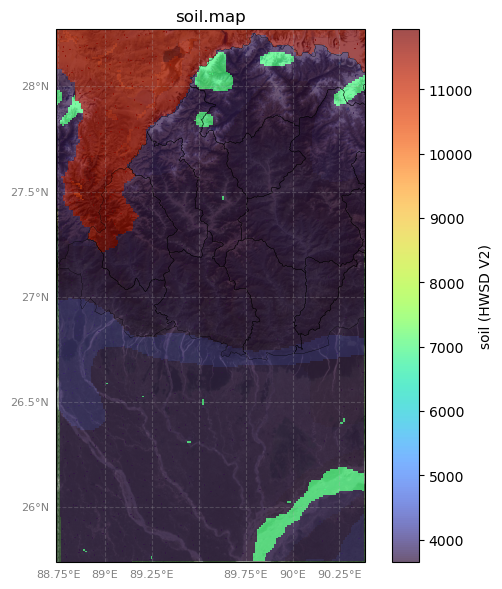

In [44]:
path_soil = os.path.join(path_data, 'SOIL', 'hwsd2_subset.tif')

print(f'- Input GEOTIFF Path for Soil Classifications:\n{path_soil}')
# pass "epsg = epsg_lonlat" as the DEM file has a different CRS (lat/lon)
map_soil = map_clone.read_raster(
    path = path_soil, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Nominal, # pcraster data type
    band = 1, # band number to read
    ) # automatically subset the input based on the clonemap extent

print('- Outputs:')
print(map_soil)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'soil.map'), # path to write in the pcraster format
    field = map_soil, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_soil)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_soil, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'soil.map', # matplotlib figure title
        clabel = 'soil (HWSD V2)', # matplotlib contour label
        savefig = None, # path to save the figure
        )

Currently, the hydrologic properties on the lookup tables are based on Harmonized World Soil Database (HWSD) V1, which requires mapping from HWSD V2 to HWSD V1.

- Input Lookup Table Path for HWSD Mapping:
../data/SOIL/HWSD2to1.tbl
- Outputs:
write_pcraster: written to ../input/soilref.map.


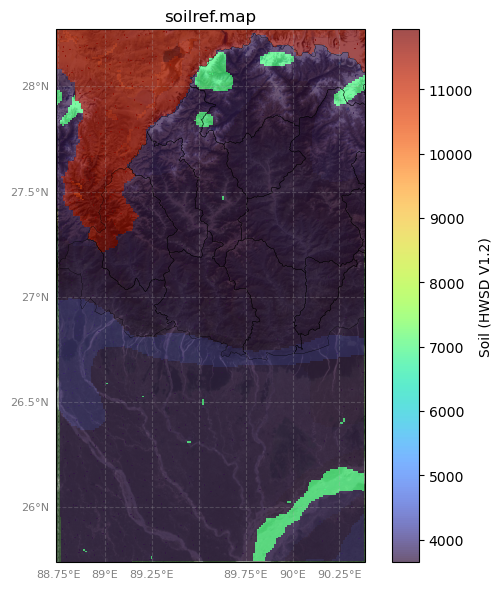

In [45]:
path_table_HWSD2to1 = os.path.join(path_data, 'SOIL', 'HWSD2to1.tbl')

print(f'- Input Lookup Table Path for HWSD Mapping:\n{path_table_HWSD2to1}')
map_soil_ref = pcr.lookupscalar(path_table_HWSD2to1, map_soil) # map pcraster.Field from HWSD V2 to V1

print('- Outputs:')
print(map_soil_ref)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'soilref.map'), # path to write in the pcraster format
    field = map_soil_ref # pcraster.Field to write
    )

#plots
if flag_plot_aguila: pcr.aguila(map_soil_ref)
if flag_plot_cartopy: map_clone.plot_cartopy(
    field = map_soil_ref, # pcraster.Field to plot
    shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
    figsize = (6, 6), # matplotlib figure size
    basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
    basemap_level = 10, # cartopy basemap zoom level
    extent = None, # cartopy map extent
    vmin = None, # matplotlib contour min
    vmax = None, # matplotlib contour max
    cmap = 'turbo', # matplotlib contour colormap
    alpha = 0.7, # matplotlib contour transparency
    title = 'soilref.map', # matplotlib figure title
    clabel = 'Soil (HWSD V1.2)', # matplotlib contour label
    savefig = None, # path to save the figure
    )

Now, we can use the Harmonized World Soil Database (HWSD) V1 soil classifications to assign hydrologic properties from the HWSD V1 lookup tables. Let's generate soil-related hydrologic properties for rootzone and subsoil layers, respectively, based on the lookup tables defined for Harmonized World Soil Database (HWSD) V1.

- field: field capacity [mm/mm]
- pwlt: permanent wilting point [mm/mm]
- satk: saturated hydraulic conductivity [mm/day]
- satwc: saturated water content [mm/mm]
- wlt: wilting point [mm/mm]

- Input Lookup Table Path for Rootzone Field Capacity:
../data/SOIL/root_field.tbl
- Outputs:
write_pcraster: written to ../input/root_field.map.


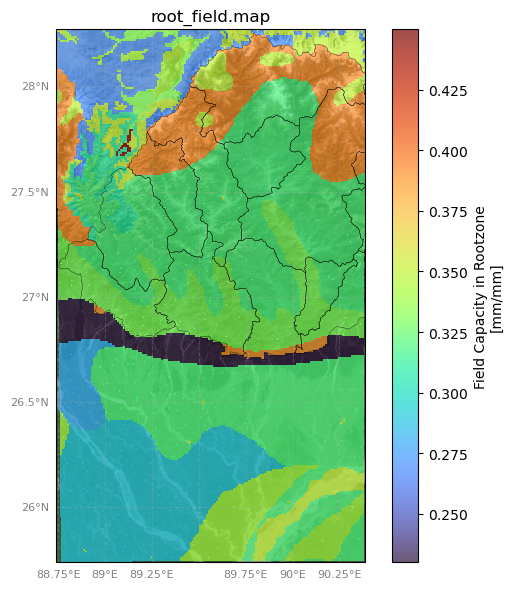

In [46]:
# field capacity in rootzone
path_table_rfield = os.path.join(path_data, 'SOIL', 'root_field.tbl') # lookup table for field capacity in rootzone [mm/mm]
print(f'- Input Lookup Table Path for Rootzone Field Capacity:\n{path_table_rfield}')
map_rfield = pcr.lookupscalar(path_table_rfield, map_soil_ref) # assign the field capacity in rootzone from the corresponding lookup table

print('- Outputs:')
print(map_rfield)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_field.map'), # path to write in the pcraster format
    field = map_rfield, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rfield)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rfield, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_field.map', # matplotlib figure title
        clabel = 'Field Capacity in Rootzone [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Lookup Table Path for Rootzone Permanent Wilting Point:
../data/SOIL/root_pwlt.tbl
- Outputs:
write_pcraster: written to ../input/root_pwlt.map.


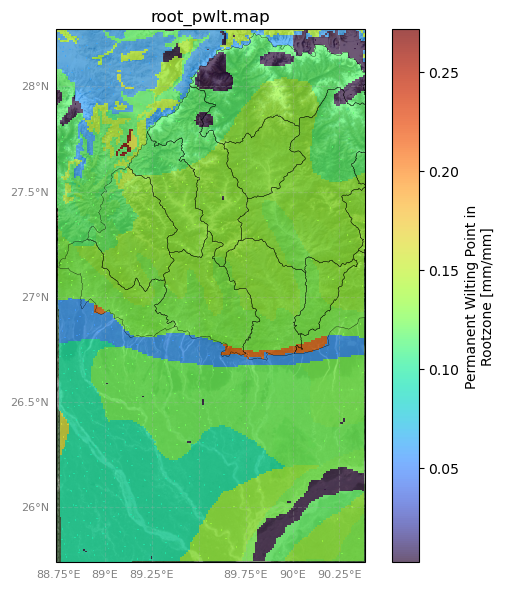

In [47]:
# permanent wilting point in rootzone
path_table_rpwlt = os.path.join(path_data, 'SOIL', 'root_pwlt.tbl') # lookup table for permanent wilting point in rootzone [mm/mm]
print(f'- Input Lookup Table Path for Rootzone Permanent Wilting Point:\n{path_table_rpwlt}')
map_rpwlt = pcr.lookupscalar(path_table_rpwlt, map_soil_ref) # assign the permanent wilting point in rootzone on the corresponding lookup table

print('- Outputs:')
print(map_rpwlt)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_pwlt.map'), # path to write in the pcraster format
    field = map_rpwlt, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rpwlt)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rpwlt, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_pwlt.map', # matplotlib figure title
        clabel = 'Permanent Wilting Point in Rootzone [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Lookup Table Path for Rootzone Saturated Hydraulic Conductivity:
../data/SOIL/root_satk.tbl
- Outputs:
write_pcraster: written to ../input/root_satk.map.


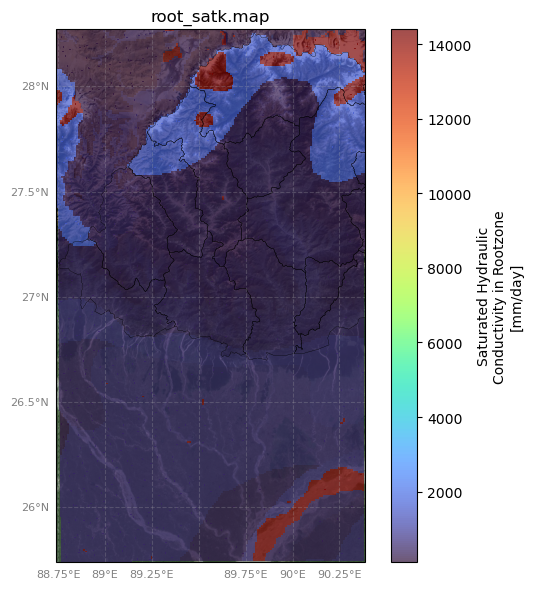

In [48]:
# saturated hydraulic conductivity in rootzone
path_table_rsatk = os.path.join(path_data, 'SOIL', 'root_satk.tbl') # lookup table for saturated hydraulic conductivity in rootzone [mm/day]
print(f'- Input Lookup Table Path for Rootzone Saturated Hydraulic Conductivity:\n{path_table_rsatk}')
map_rsatk = pcr.lookupscalar(path_table_rsatk, map_soil_ref) # assign the saturated hydraulic conductivity in rootzone on the corresponding lookup table

print('- Outputs:')
print(map_rsatk)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_satk.map'), # path to write in the pcraster format
    field = map_rsatk, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rsatk)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rsatk, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_satk.map', # matplotlib figure title
        clabel = 'Saturated Hydraulic Conductivity in Rootzone [mm/day]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Lookup Table Path for Rootzone Saturated Water Content:
../data/SOIL/root_satwc.tbl
- Outputs:
write_pcraster: written to ../input/root_satwc.map.


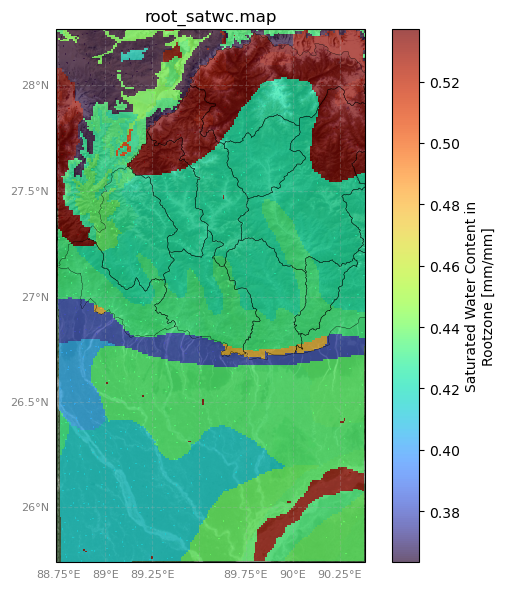

In [49]:
# saturated water content in rootzone
path_table_rsatwc = os.path.join(path_data, 'SOIL', 'root_satwc.tbl') # lookup table for saturated water content in rootzone [mm/mm]
print(f'- Input Lookup Table Path for Rootzone Saturated Water Content:\n{path_table_rsatwc}')
map_rsatwc = pcr.lookupscalar(path_table_rsatwc, map_soil_ref) # assign the saturated water content in rootzone on the corresponding lookup table

print('- Outputs:')
print(map_rsatwc)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_satwc.map'), # path to write in the pcraster format
    field = map_rsatwc, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rsatwc)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rsatwc, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_satwc.map', # matplotlib figure title
        clabel = 'Saturated Water Content in Rootzone [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Lookup Table Path for Rootzone Wilting Point:
../data/SOIL/root_wlt.tbl
- Outputs:
write_pcraster: written to ../input/root_wlt.map.


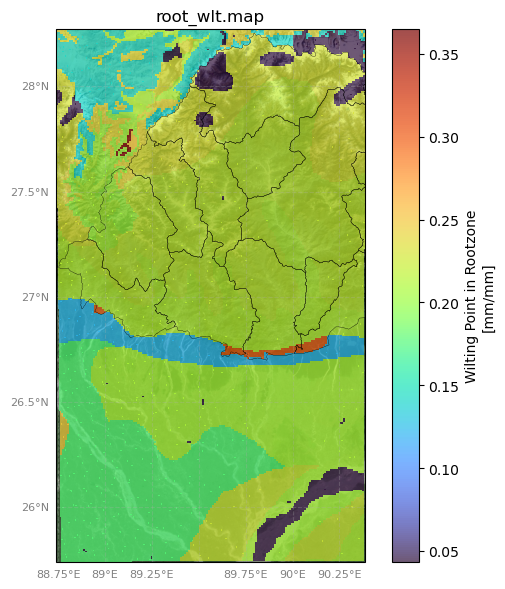

In [50]:
# wilting point in rootzone
path_table_rwlt = os.path.join(path_data, 'SOIL', 'root_wlt.tbl') # lookup table for wilting point in rootzone [mm/mm]
print(f'- Input Lookup Table Path for Rootzone Wilting Point:\n{path_table_rwlt}')
map_rwlt = pcr.lookupscalar(path_table_rwlt, map_soil_ref) # assign the wilting point in rootzone on the corresponding lookup table

print('- Outputs:')
print(map_rwlt)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_wlt.map'), # path to write in the pcraster format
    field = map_rwlt, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rwlt)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rwlt, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_wlt.map', # matplotlib figure title
        clabel = 'Wilting Point in Rootzone [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Lookup Table Path for Subsoil Field Capacity:
../data/SOIL/sub_field.tbl
- Outputs:
write_pcraster: written to ../input/sub_field.map.


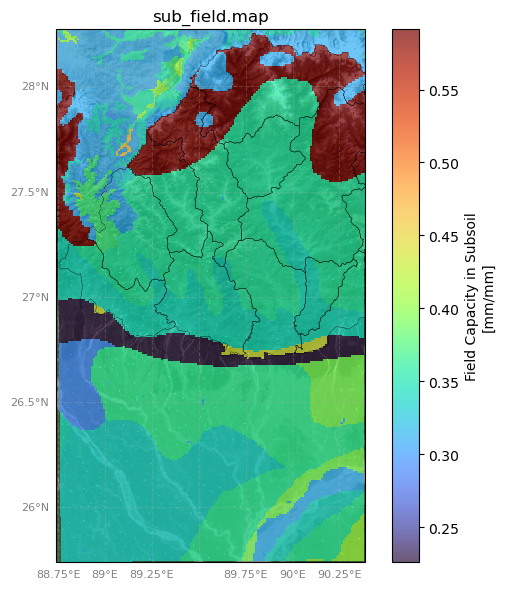

In [51]:
# field capacity in subsoil
path_table_sfield = os.path.join(path_data, 'SOIL', 'sub_field.tbl') # lookup table for field capacity in subsoil [mm/mm]
print(f'- Input Lookup Table Path for Subsoil Field Capacity:\n{path_table_sfield}')
map_sfield = pcr.lookupscalar(path_table_sfield, map_soil_ref) # assign the field capacity in subsoil on the corresponding lookup table

print('- Outputs:')
print(map_sfield)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'sub_field.map'), # path to write in the pcraster format
    field = map_sfield, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_sfield)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_sfield, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'sub_field.map', # matplotlib figure title
        clabel = 'Field Capacity in Subsoil [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Lookup Table Path for Subsoil Saturated Hydraulic Conductivity:
../data/SOIL/sub_satk.tbl
- Outputs:
write_pcraster: written to ../input/sub_satk.map.


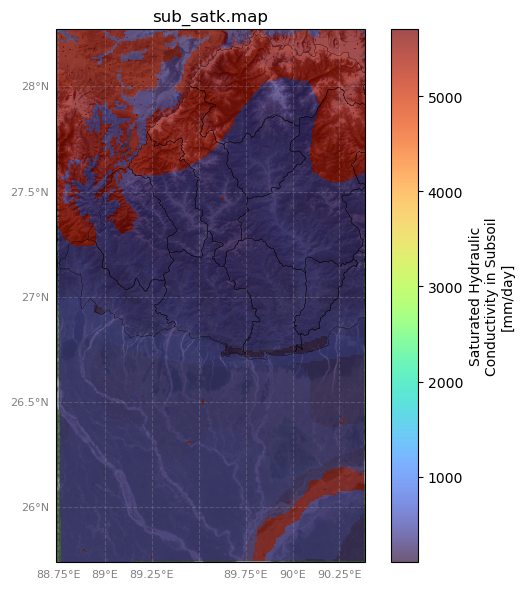

In [52]:
# saturated hydraulic conductivity in subsoil
path_table_ssatk = os.path.join(path_data, 'SOIL', 'sub_satk.tbl') # lookup table for saturated hydraulic conductivity in subsoil [mm/day]
print(f'- Input Lookup Table Path for Subsoil Saturated Hydraulic Conductivity:\n{path_table_ssatk}')
map_ssatk = pcr.lookupscalar(path_table_ssatk, map_soil_ref) # assign the saturated hydraulic conductivity in subsoil on the corresponding lookup table

print('- Outputs:')
print(map_ssatk)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'sub_satk.map'), # path to write in the pcraster format
    field = map_ssatk, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_ssatk)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_ssatk, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'sub_satk.map', # matplotlib figure title
        clabel = 'Saturated Hydraulic Conductivity in Subsoil [mm/day]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Lookup Table Path for Subsoil Saturated Water Content:
../data/SOIL/sub_satwc.tbl
- Outputs:
write_pcraster: written to ../input/sub_satwc.map.


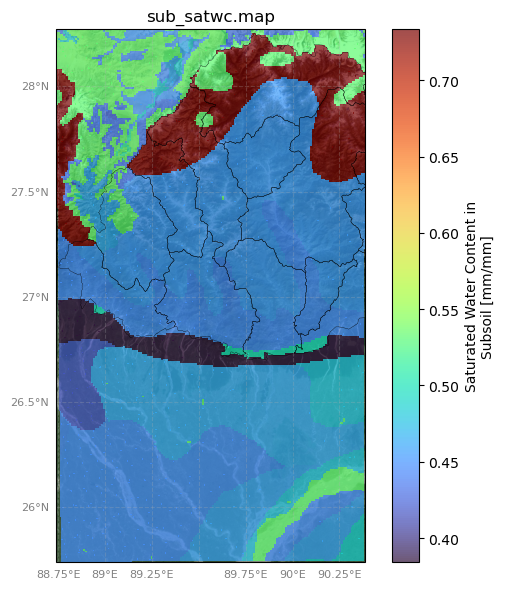

In [53]:
# saturated water content in subsoil
path_table_ssatwc = os.path.join(path_data, 'SOIL', 'sub_satwc.tbl') # lookup table for saturated water content in subsoil [mm/mm]
print(f'- Input Lookup Table Path for Subsoil Saturated Water Content:\n{path_table_ssatwc}')
map_ssatwc = pcr.lookupscalar(path_table_ssatwc, map_soil_ref) # assign the saturated water content in subsoil on the corresponding lookup table

print('- Outputs:')
print(map_ssatwc)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'sub_satwc.map'), # path to write in the pcraster format
    field = map_ssatwc, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_ssatwc)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_ssatwc, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'sub_satwc.map', # matplotlib figure title
        clabel = 'Saturated Water Content in Subsoil [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

**ALTERNATIVE**: If the hydrologic properties are available geospatially from a set of rasters (e.g.,HiHydroSoil 250m), we can directly generate them by importing the raster files.

- Input Raster Path for Rootzone Field Capacity:
../data/SOIL/WCpF2_M_250m_TOPSOIL_subset.tif
- Outputs:
write_pcraster: written to ../input/root_field_HHS.map.


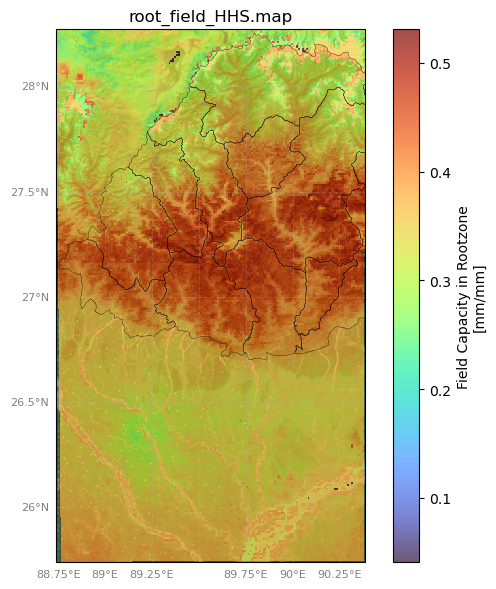

In [54]:
# field capacity in rootzone
path_rfield_HHS = os.path.join(path_data, 'SOIL', 'WCpF2_M_250m_TOPSOIL_subset.tif') # raster for field capacity in rootzone [mm/mm]
print(f'- Input Raster Path for Rootzone Field Capacity:\n{path_rfield_HHS}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_rfield_HHS = map_clone.read_raster(
    path = path_rfield_HHS, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_rfield_HHS)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_field_HHS.map'), # path to write in the pcraster format
    field = map_rfield_HHS, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rfield_HHS)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rfield_HHS, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_field_HHS.map', # matplotlib figure title
        clabel = 'Field Capacity in Rootzone [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Raster Path for Rootzone Permanent Wilting Point:
../data/SOIL/WCpF4.2_M_250m_TOPSOIL_subset.tif
- Outputs:
write_pcraster: written to ../input/root_pwlt_HHS.map.


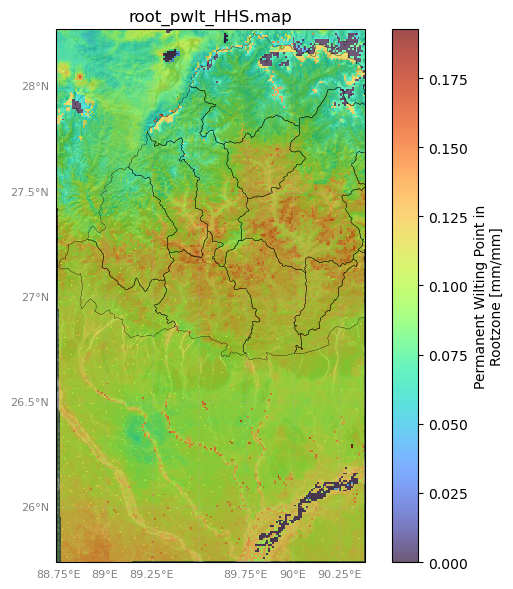

In [55]:
# permanent wilting point in rootzone
path_rpwlt_HHS = os.path.join(path_data, 'SOIL', 'WCpF4.2_M_250m_TOPSOIL_subset.tif') # raster for permanent wilting point in rootzone [mm/mm]
print(f'- Input Raster Path for Rootzone Permanent Wilting Point:\n{path_rpwlt_HHS}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_rpwlt_HHS = map_clone.read_raster(
    path = path_rpwlt_HHS, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_rpwlt_HHS)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_pwlt_HHS.map'), # path to write in the pcraster format
    field = map_rpwlt_HHS, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rpwlt_HHS)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rpwlt_HHS, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_pwlt_HHS.map', # matplotlib figure title
        clabel = 'Permanent Wilting Point in Rootzone [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Raster Path for Rootzone Saturated Hydraulic Conductivity:
../data/SOIL/Ksat_M_250m_TOPSOIL_subset.tif
- Outputs:
write_pcraster: written to ../input/root_satk_HHS.map.


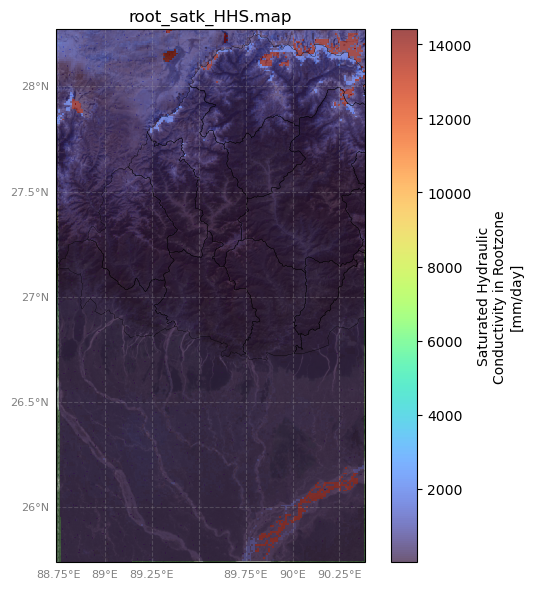

In [56]:
# saturated hydraulic conductivity in rootzone
path_rsatk_HHS = os.path.join(path_data, 'SOIL', 'Ksat_M_250m_TOPSOIL_subset.tif') # raster for saturated hydraulic conductivity in rootzone [mm/day]
print(f'- Input Raster Path for Rootzone Saturated Hydraulic Conductivity:\n{path_rsatk_HHS}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_rsatk_HHS = map_clone.read_raster(
    path = path_rsatk_HHS, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_rsatk_HHS)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_satk_HHS.map'), # path to write in the pcraster format
    field = map_rsatk_HHS, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rsatk_HHS)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rsatk_HHS, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_satk_HHS.map', # matplotlib figure title
        clabel = 'Saturated Hydraulic Conductivity in Rootzone [mm/day]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Raster Path for Rootzone Saturated Water Content:
../data/SOIL/WCsat_M_250m_TOPSOIL_subset.tif
- Outputs:
write_pcraster: written to ../input/root_satwc_HHS.map.


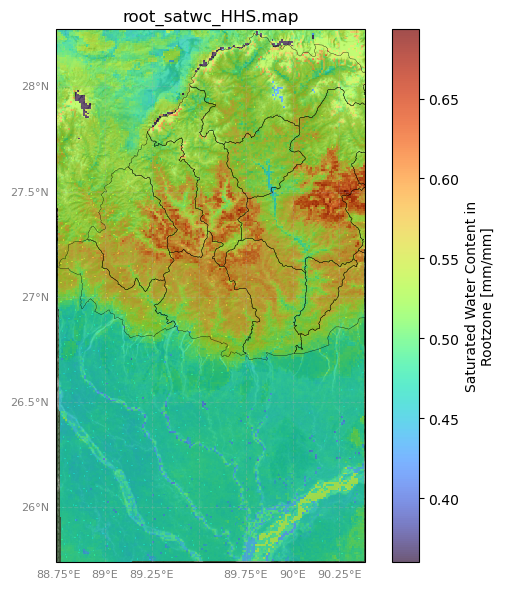

In [57]:
# saturated water content in rootzone
path_rsatwc_HHS = os.path.join(path_data, 'SOIL', 'WCsat_M_250m_TOPSOIL_subset.tif') # raster for saturated water content in rootzone [mm/mm]
print(f'- Input Raster Path for Rootzone Saturated Water Content:\n{path_rsatwc_HHS}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_rsatwc_HHS = map_clone.read_raster(
    path = path_rsatwc_HHS, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_rsatwc_HHS)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_satwc_HHS.map'), # path to write in the pcraster format
    field = map_rsatwc_HHS, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rsatwc_HHS)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rsatwc_HHS, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_satwc_HHS.map', # matplotlib figure title
        clabel = 'Saturated Water Content in Rootzone [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Raster Path for Rootzone Wilting Point:
../data/SOIL/WCpF3_M_250m_TOPSOIL_subset.tif
- Outputs:
write_pcraster: written to ../input/root_wlt_HHS.map.


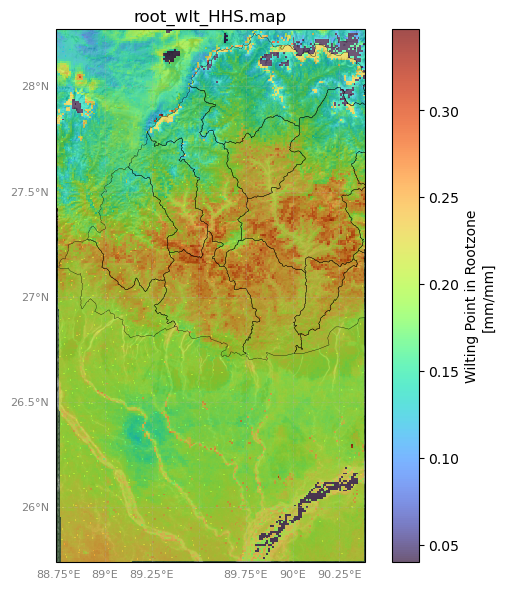

In [58]:
# wilting point in rootzone
path_rwlt_HHS = os.path.join(path_data, 'SOIL', 'WCpF3_M_250m_TOPSOIL_subset.tif') # raster for wilting point in rootzone [mm/mm]
print(f'- Input Raster Path for Rootzone Wilting Point:\n{path_rwlt_HHS}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_rwlt_HHS = map_clone.read_raster(
    path = path_rwlt_HHS, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_rwlt_HHS)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'root_wlt_HHS.map'), # path to write in the pcraster format
    field = map_rwlt_HHS, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_rwlt_HHS)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_rwlt_HHS, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'root_wlt_HHS.map', # matplotlib figure title
        clabel = 'Wilting Point in Rootzone [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Raster Path for Subsoil Field Capacity:
../data/SOIL/WCpF2_M_250m_SUBSOIL_subset.tif
- Outputs:
write_pcraster: written to ../input/sub_field_HHS.map.


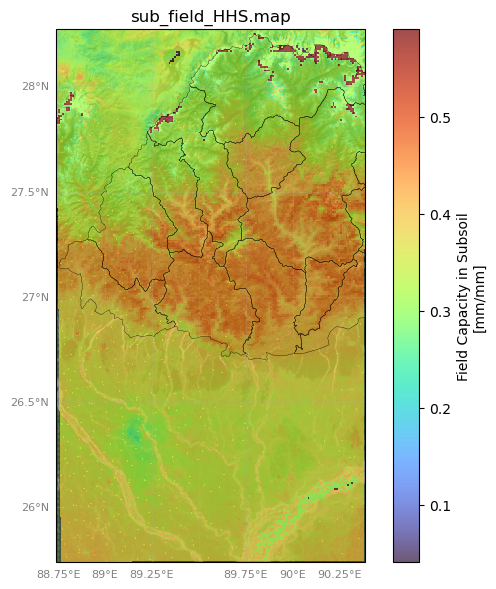

In [59]:
# field capacity in subsoil
path_sfield_HHS = os.path.join(path_data, 'SOIL', 'WCpF2_M_250m_SUBSOIL_subset.tif') # raster for field capacity in subsoil [mm/mm]
print(f'- Input Raster Path for Subsoil Field Capacity:\n{path_sfield_HHS}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_sfield_HHS = map_clone.read_raster(
    path = path_sfield_HHS, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_sfield_HHS)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'sub_field_HHS.map'), # path to write in the pcraster format
    field = map_sfield_HHS, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_sfield_HHS)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_sfield_HHS, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'sub_field_HHS.map', # matplotlib figure title
        clabel = 'Field Capacity in Subsoil [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Raster Path for Subsoil Saturated Hydraulic Conductivity:
../data/SOIL/Ksat_M_250m_SUBSOIL_subset.tif
- Outputs:
write_pcraster: written to ../input/sub_satk_HHS.map.


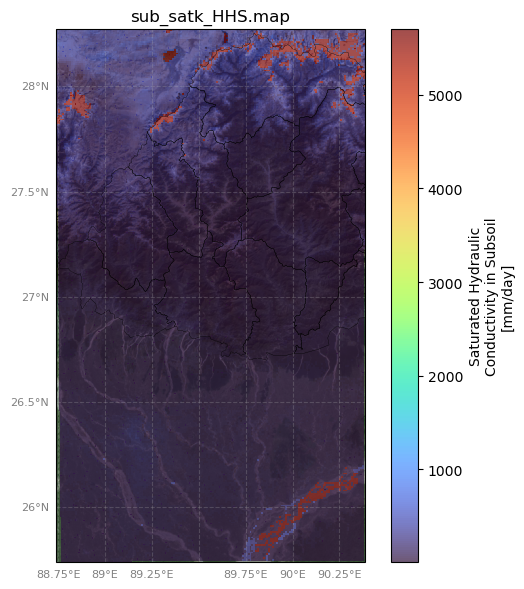

In [60]:
# saturated hydraulic conductivity in subsoil
path_ssatk_HHS = os.path.join(path_data, 'SOIL', 'Ksat_M_250m_SUBSOIL_subset.tif') # raster for saturated hydraulic conductivity in subsoil [mm/day]
print(f'- Input Raster Path for Subsoil Saturated Hydraulic Conductivity:\n{path_ssatk_HHS}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_ssatk_HHS = map_clone.read_raster(
    path = path_ssatk_HHS, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_ssatk_HHS)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'sub_satk_HHS.map'), # path to write in the pcraster format
    field = map_ssatk_HHS, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_ssatk_HHS)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_ssatk_HHS, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'sub_satk_HHS.map', # matplotlib figure title
        clabel = 'Saturated Hydraulic Conductivity in Subsoil [mm/day]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

- Input Raster Path for Subsoil Saturated Water Content:
../data/SOIL/WCsat_M_250m_SUBSOIL_subset.tif
- Outputs:
write_pcraster: written to ../input/sub_satwc_HHS.map.


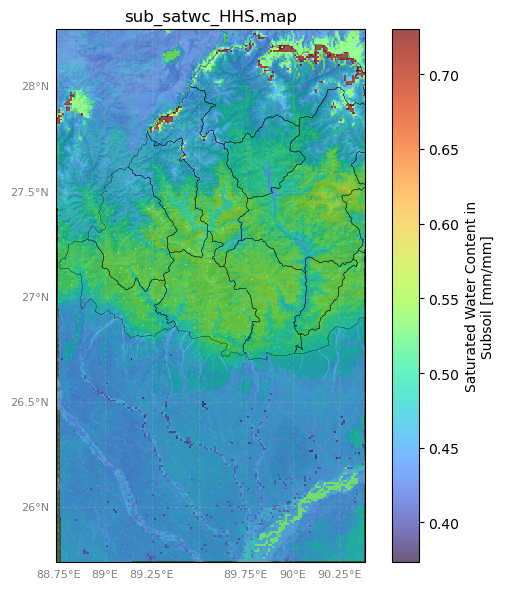

In [61]:
# saturated water content in subsoil
path_ssatwc_HHS = os.path.join(path_data, 'SOIL', 'WCsat_M_250m_SUBSOIL_subset.tif') # raster for saturated water content in subsoil [mm/mm]
print(f'- Input Raster Path for Subsoil Saturated Water Content:\n{path_ssatwc_HHS}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_ssatwc_HHS = map_clone.read_raster(
    path = path_ssatwc_HHS, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Scalar, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_ssatwc_HHS)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'sub_satwc_HHS.map'), # path to write in the pcraster format
    field = map_ssatwc_HHS, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_ssatwc_HHS)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_ssatwc_HHS, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'sub_satwc_HHS.map', # matplotlib figure title
        clabel = 'Saturated Water Content in Subsoil [mm/mm]', # matplotlib contour label
        savefig = None, # path to save the figure
        )

## 04. Set Land-Related Hydrologic Properties

Next, we're going to generate a land use/cover pcraster map (e.g., NASA MODIS Land Cover), which will be combined with a lookup table for the crop coefficients by the SPHY model.

- Input Raster Path for Land Use/Cover:
../data/LAND/MCD12Q1.A2001001.tif
- Outputs:
write_pcraster: written to ../input/luse.map.


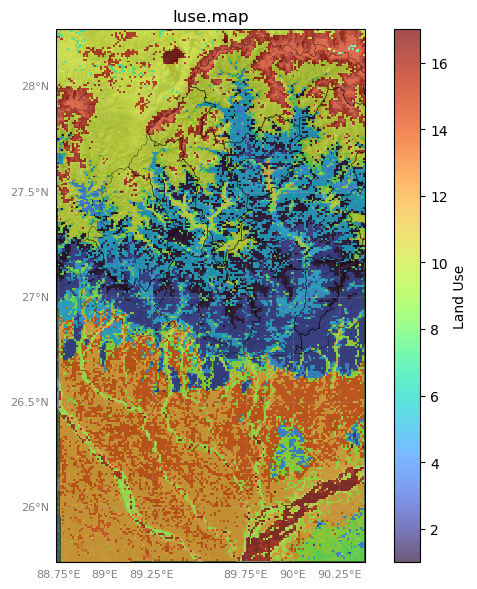

In [62]:
path_luse = os.path.join(path_data, 'LAND', 'MCD12Q1.A2001001.tif')
print(f'- Input Raster Path for Land Use/Cover:\n{path_luse}')
# pass "epsg = epsg_check" as the input file has a different CRS (lat/lon)
map_luse = map_clone.read_raster(
    path = path_luse, # geotiff path to read
    epsg = epsg_lonlat, # input EPSG
    datatype = pcr.Nominal, # pcraster data type
    band = 1, # band number to read
    )

print('- Outputs:')
print(map_luse)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'luse.map'), # path to write in the pcraster format
    field = map_luse, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_luse)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_luse, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'luse.map', # matplotlib figure title
        clabel = 'Land Use', # matplotlib contour label
        savefig = None, # path to save the figure
        )

Then, we need to define the crop coefficients in *kc.tbl* with respect to the land use/cover classification. You will see that the crop coefficients are arbitrarily assigned in *kc.tbl*, which requires furture updates through estimations or calibrations.

In [63]:
with open(file = os.path.join(path_data, 'kc.tbl'), mode = 'r') as f:
    for l in f:
        print(l)

0 0.0

1 1.0

2 1.0

3 1.0

4 1.0

5 1.0

6 1.0

7 1.0

8 1.0

9 1.0

10 1.0

11 1.0

12 1.0

13 1.0

14 1.0

15 1.0

16 1.0

254 0.0

255 0.0


Anyway, please do not forget to copy *kc.tbl* into the SPHY input folder.

In [64]:
shutil.copyfile(src = os.path.join(path_data, 'kc.tbl'), dst = os.path.join(path_output, 'kc.tbl'))

'../input/kc.tbl'

Lastly, the SPHY model requires a latitude pcraster map to calculate extraterrestrial radiation.

- Outputs:
write_pcraster: written to ../input/latitude.map.


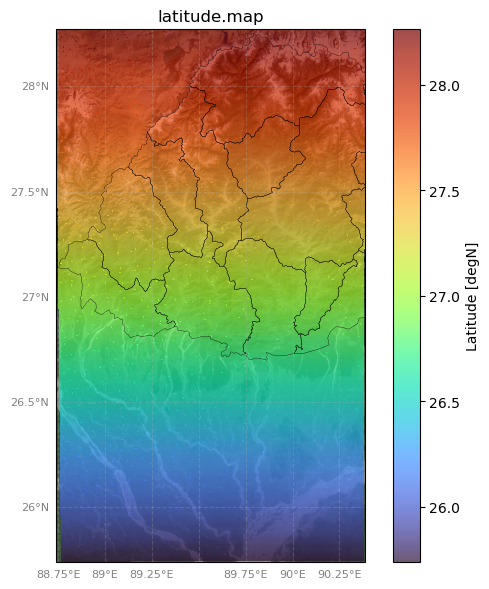

In [65]:
map_latitude = map_clone.create_latitude()

print('- Outputs:')
print(map_latitude)

# export into a pcraster file
map_clone.write_pcraster(
    path = os.path.join(path_output, 'latitude.map'), # path to write in the pcraster format
    field = map_latitude, # pcraster.Field to write
    )

# plots
if flag_plot_aguila: pcr.aguila(map_latitude)
if flag_plot_cartopy:
    map_clone.plot_cartopy(
        field = map_latitude, # pcraster.Field to plot
        shapes = [shape_feature], # a list of cartopy.feature.ShapelyFeature to plot together
        figsize = (6, 6), # matplotlib figure size
        basemap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite'), # cartopy basemap (here, Google Satellite Images)
        basemap_level = 10, # cartopy basemap zoom level
        extent = None, # cartopy map extent
        vmin = None, # matplotlib contour min
        vmax = None, # matplotlib contour max
        cmap = 'turbo', # matplotlib contour colormap
        alpha = 0.7, # matplotlib contour transparency
        title = 'latitude.map', # matplotlib figure title
        clabel = 'Latitude [degN]', # matplotlib contour label
        savefig = None, # path to save the figure
        )